# MLP - perceptron wielowarstwowy

Zadanie do wykonania:
1. Przygotuj zbiór bank, a następnie zaprojektuj model sieci neuronowej MLP za pomocą czterech bibilotek:
    - amore
    - nnet
    - rsnns
    - neuralnet 

 Wczytanie zbioru bank, a następnie dokonanie normalizacji danych.
 Celem klasyfikacji jest przewidzenie, czy klient zapisze się na lokatę terminową (zmienna y).
   bank client data:
   - age (numeric)
   - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                        "blue-collar","self-employed","retired","technician","services") 
  - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
  - education (categorical: "unknown","secondary","primary","tertiary")
  - default: has credit in default? (binary: "yes","no")
  - balance: average yearly balance, in euros (numeric) 
  - housing: has housing loan? (binary: "yes","no")
  - loan: has personal loan? (binary: "yes","no")
  related with the last contact of the current campaign:
  - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  - day: last contact day of the month (numeric)
  - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  - duration: last contact duration, in seconds (numeric)
  other attributes:
  - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  - previous: number of contacts performed before this campaign and for this client (numeric)
  - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

1. BIBLIOTEKA AMORE

In [194]:
# library(BCA)
# library(relimp)
# library(RcmdrMisc)
# library(sqldf)
library(dplyr)
# library(dummies)
# library(AMORE)
library(caret)


In [195]:
bank <- read.csv("bank.csv", sep=";")
bank_full <- read.csv("bank-full.csv", sep=";")

Kodowanie i normalizacja

In [196]:
normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}
# bank$default <- ifelse(bank$default == "yes", 1, 0)
# bank$housing <- ifelse(bank$housing == "yes", 1, 0)
# bank$loan <- ifelse(bank$loan == "yes", 1, 0)
miesiace <- c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec")
bank$month <- match(bank$month, miesiace)
bank<-bank %>%
    mutate(balance = normalize(balance)) %>%
mutate(duration = normalize(duration)) %>%
mutate(pdays = normalize(pdays)) 
y_bank<-bank$y
bank$y<-NULL
dummies <- dummyVars(~ ., data = bank)
bank <- predict(dummies, newdata = bank)

bank<-data.frame(bank)
bank$y<-y_bank
bank$y <- as.numeric(bank$y == "yes")
head(bank)

,age,jobadmin.,jobblue.collar,jobentrepreneur,jobhousemaid,jobmanagement,jobretired,jobself.employed,jobservices,jobstudent,⋯,month,duration,campaign,pdays,previous,poutcomefailure,poutcomeother,poutcomesuccess,poutcomeunknown,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30,0,0,0,0,0,0,0,0,0,⋯,10,0.02482622,1,0.0000000,0,0,0,0,1,0
2,33,0,0,0,0,0,0,0,1,0,⋯,5,0.07149950,1,0.3899083,4,1,0,0,0,0
3,35,0,0,0,0,1,0,0,0,0,⋯,4,0.05991394,1,0.3795872,1,1,0,0,0,0
4,30,0,0,0,0,1,0,0,0,0,⋯,6,0.06454816,4,0.0000000,0,0,0,0,1,0
5,59,0,1,0,0,0,0,0,0,0,⋯,5,0.07348560,1,0.0000000,0,0,0,0,1,0
6,35,0,0,0,0,1,0,0,0,0,⋯,2,0.04534922,2,0.2029817,3,1,0,0,0,0


Podział na dane walidacyjne i treningowe

In [197]:
indices <- sample(seq_len(nrow(bank)))
n <- nrow(bank)
train_indices <- round(0.60 * n)
validate_indices <- round(0.40 * n)

In [198]:
bank_train <- bank[indices[1:train_indices], ]
bank_valid <- bank[indices[(train_indices + 1):(train_indices + validate_indices)], ]

In [199]:

y_train<-bank_train$y
bank_train$y<-NULL
y_valid<-bank_valid$y
bank_valid$y<-NULL
print(dim(bank_train)) 
print(dim(bank_valid))
print(is.vector(y_train))  
print(is.vector(y_valid))

[1] 2713   40
[1] 1808   40
[1] TRUE
[1] TRUE


In [43]:
library(AMORE)
net <- newff(
  n.neurons = c(ncol(bank_train), 100,50,60, 1), 
  learning.rate.global = 0.001,
  momentum.global = 0.9,
  error.criterium = "LMS", 
  hidden.layer = "sigmoid",
  output.layer = "purelin",
  method = "ADAPTgdwm"
)
#net <- newff(n.neurons=c(3,10,10,1), learning.rate.global=1e-2, momentum.global=0.5, error.criterium="TAO", Stao=NA, hidden.layer="tansig",output.layer="purelin", method="ADAPTgdwm")

In [44]:
result <- train(
  net, 
  bank_train, 
  y_train, 
  bank_valid, 
  y_valid,
  error.criterium = "LMS", 
  report = TRUE, 
  show.step = 100, 
  n.shows = 30
)

index.show: 1 LMS 	TRAIN: 0.0971427962046091 	VAL: 0.110367233681282 	 BEST NET
index.show: 2 LMS 	TRAIN: 0.0969430244595024 	VAL: 0.10988232649551 	 BEST NET
index.show: 3 LMS 	TRAIN: 0.0969078539677509 	VAL: 0.109784161756323 	 BEST NET
index.show: 4 LMS 	TRAIN: 0.0965832998363686 	VAL: 0.109489196350158 	 BEST NET
index.show: 5 LMS 	TRAIN: 0.0926727537087325 	VAL: 0.104991732783671 	 BEST NET
index.show: 6 LMS 	TRAIN: 0.091013148470461 	VAL: 0.102944262286126 	 BEST NET
index.show: 7 LMS 	TRAIN: 0.0896737534718957 	VAL: 0.10177748830621 	 BEST NET
index.show: 8 LMS 	TRAIN: 0.0876214787799219 	VAL: 0.100084092028352 	 BEST NET
index.show: 9 LMS 	TRAIN: 0.0846400964780847 	VAL: 0.0971469517458482 	 BEST NET
index.show: 10 LMS 	TRAIN: 0.0816102200168462 	VAL: 0.0936333534632855 	 BEST NET
index.show: 11 LMS 	TRAIN: 0.0790233533383372 	VAL: 0.0910642228705899 	 BEST NET
index.show: 12 LMS 	TRAIN: 0.0764847265491794 	VAL: 0.0891778061109007 	 BEST NET
index.show: 13 LMS 	TRAIN: 0.0742496

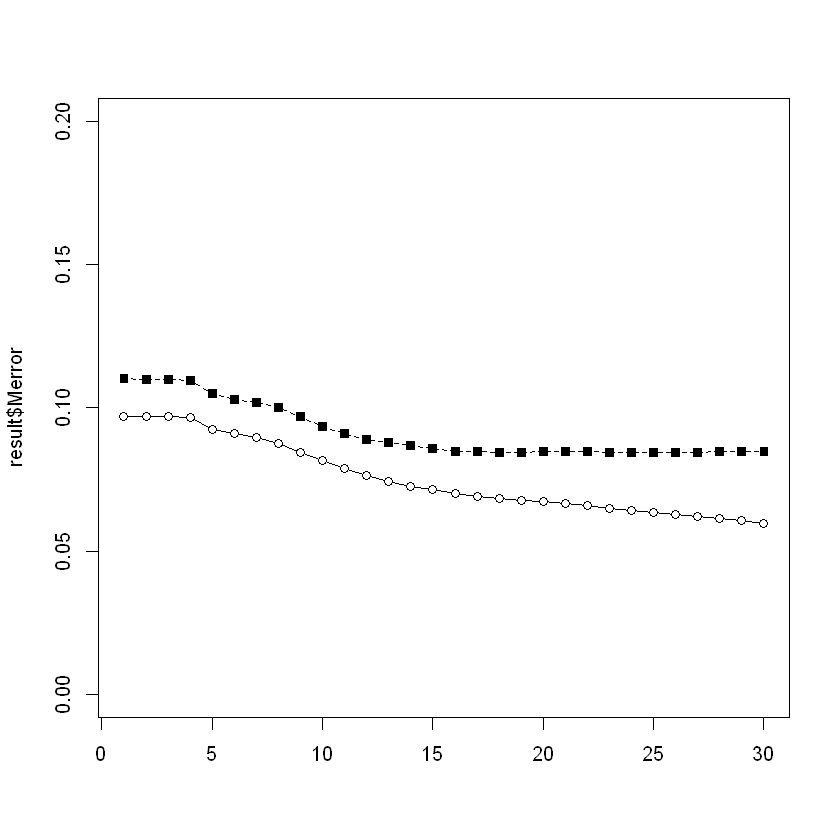

In [45]:
WYSN<-sim(result$net,bank_valid)
WYSN<-round(WYSN,0)
wynik<- data.frame(y_valid,WYSN)
matplot(result$Merror, pch=21:23, bg=c("white",  "black"), type="o",col="black", xlim=c(1, 30), ylim=c(0,0.2))

In [46]:
WYSN<-factor(WYSN)
VAL_WY<-factor(y_valid)
library(caret)
confusionMatrix(WYSN,VAL_WY)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1553  179
         1   29   47
                                          
               Accuracy : 0.885           
                 95% CI : (0.8693, 0.8993)
    No Information Rate : 0.875           
    P-Value [Acc > NIR] : 0.1057          
                                          
                  Kappa : 0.265           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9817          
            Specificity : 0.2080          
         Pos Pred Value : 0.8967          
         Neg Pred Value : 0.6184          
             Prevalence : 0.8750          
         Detection Rate : 0.8590          
   Detection Prevalence : 0.9580          
      Balanced Accuracy : 0.5948          
                                          
       'Positive' Class : 0               
                        

Wnioski
1. Na podstawie ustawień sieci neuronowej:
 - Globalna szybkość uczenia ustawiona na 0.001. Jest to stosunkowo mała wartość, która pomaga w stabilnej konwergencji, ale w zamian za to sprawia, że proces uczenia jest wolniejszy
 - Ustawiona wyższa wartość momentum, która pomaga uniknąć lokalnych minimów poprzez "pamiętanie" poprzednich kierunków aktualizacji wag.
 - Kryterium błędu to "Least Mean Squares" (LMS). Kryterium minimalizacji średniego błędu kwadratowego, jest to standard w problemach regresji.
 - Zastosowanie wielu warstw ukrytych z różnymi liczbami neuronów wskazuje na zdolność sieci do uchwycenia skomplikowanych wzorców i nieliniowych zależności w danych. Jednak zbyt duża liczba neuronów może prowadzić do przeuczenia.
 - została zastosowana funkcja aktywacji sigmoid, gdyż to popularna funkcja w klasyfikacji binarnej jej wyjście jest ograniczone do zakresu (0, 1), co można interpretować jako prawdopodobieństwo przynależności do danej klasy.
 2. Na podstawie powyższego raportu:
 - dokładność modelu wynosi: 88,5%
 - współczynnik kappa wynosi, co oznacza, iż w 26,5% poprawnie dopasowywuje się do nowych danych, nie jest on wystarczająco zadowalający, ale oznacza to, że lepiej byłoby skorzystać z modelu niż próbować klasyfikować w losowy sposób
 - wykres funkcji straty jest zgodny z założeniami to znaczy wartość funkcji straty w każdej epoce maleje
 - spośród przeprowadzonych eksperymentów najlepsza sieć jest dla 3 warstw ukrytych, które mają odpowiednio 100,50,60 neuronów. 
 - większa liczba warstw ukrytych powoduje przeuczenie modelu i gorzej dostosowuje się on do nowych danych

2. BIBLIOTEKA NNET

In [8]:
library(nnet)
library(caret)
library(NeuralNetTools)

Warning message:
"pakiet 'nnet' został zbudowany w wersji R 4.3.3"
Warning message:
"pakiet 'NeuralNetTools' został zbudowany w wersji R 4.3.3"


In [200]:
bank_train$y <- y_train
bank_valid$y <- y_valid

In [201]:
bank_train1<- bank_train
bank_valid1<- bank_valid
bank_train1$y<-factor(bank_train1$y)
bank_valid1$y<-factor(bank_valid1$y)

print(dim(bank_train)) 
print(dim(bank_valid))

[1] 2713   41
[1] 1808   41


In [115]:
nn1 <- nnet(y ~., data = bank_train1, size = 23,decay = 5e-4, maxit = 210)

# weights:  967


initial  value 3639.515971 
iter  10 value 929.014865
iter  20 value 869.719464
iter  30 value 825.572157
iter  40 value 710.189735
iter  50 value 598.591311
iter  60 value 565.080254
iter  70 value 543.932784
iter  80 value 521.958533
iter  90 value 506.431558
iter 100 value 494.171824
iter 110 value 481.539413
iter 120 value 465.738967
iter 130 value 454.740529
iter 140 value 445.520827
iter 150 value 440.533321
iter 160 value 438.859273
iter 170 value 438.063302
iter 180 value 433.177974
iter 190 value 424.966648
iter 200 value 417.644445
iter 210 value 412.265189
final  value 412.265189 
stopped after 210 iterations


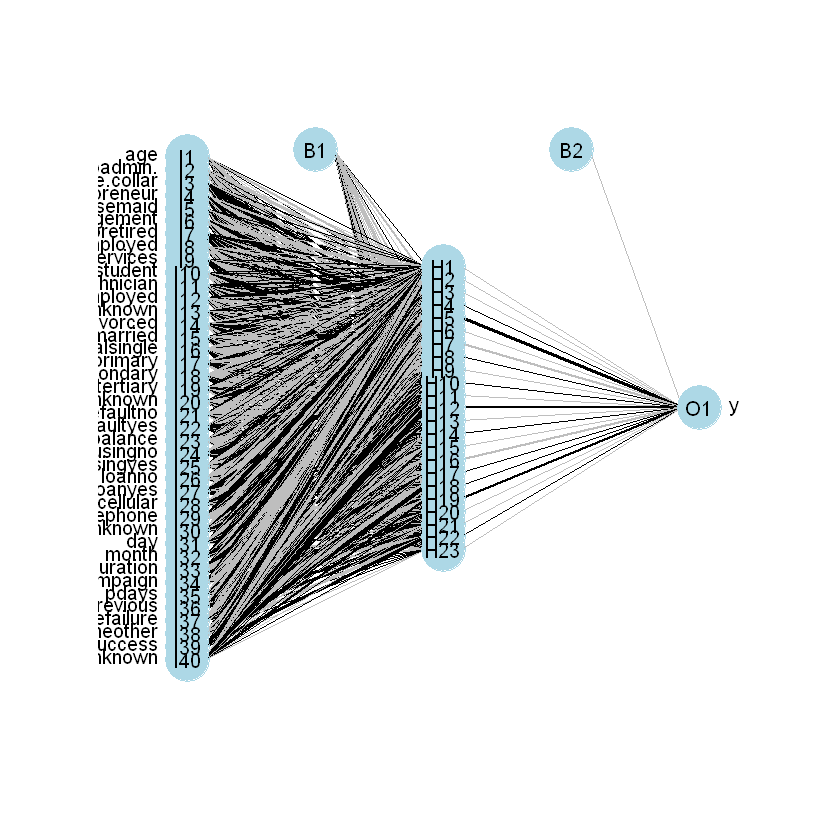

In [116]:
plotnet(nn1, struct = struct)

In [117]:
neuralweights(nn1)

result<-predict(nn1,newdata=bank_train1, type='class')
result<-factor(as.integer(result))
confusionMatrix(result,bank_train1$y)


result_val<-predict(nn1,newdata=bank_valid1, type='class')
result_val<-factor(as.integer(result_val))
confusionMatrix(result_val,bank_valid1$y)
#head(bank_train)

$struct
[1] 40 23  1

$wts
$wts$`hidden 1 1`
 [1]  0.138675634  0.351918006 -0.281984819  0.076296029  0.100231806
 [6]  0.006718255 -0.044577261 -0.236425519 -0.121750180  0.326780503
[11]  0.194287446  0.186345636  0.106336522 -0.255567211  0.127321377
[16]  0.289021720 -0.068582541 -0.281685220 -0.052976331  0.236322021
[21] -0.086462954  0.251198365  0.140276882 -0.296178181 -0.313183595
[26]  0.250107723 -0.130031906  0.185538036 -0.225754748 -0.120861330
[31]  0.033147831  0.117455598  0.054835226  0.062300046  0.207566090
[36] -0.058103238 -0.259916308 -0.197345852 -0.249748295 -0.172729825
[41]  0.211876407

$wts$`hidden 1 2`
 [1]  -6.5397782  -4.5837786  -8.8734485  -4.1261645  -4.5928065   3.1617877
 [7]  -7.6419527   6.6609736  -6.3151538  -2.5026476   3.0219019   4.2461583
[13]   7.6843118   0.5310988  -3.4513445   1.7443337  -5.7436860  -3.4778596
[19]  -7.3253982   1.5241641   2.8327483   3.3350842 -10.4297873   2.3014861
[25] -11.2873988   4.7553230   0.6727944  -7.1421864  -7.3880920  12.8669512
[31] -13.2391904   6.9742186   2.3908792 -10.5587744   6.1293266  -1.4248180
[37] -13.3801368 -10.4304449   0.7598055  -4.5718648   7.3337350

$wts$`hidden 1 3`
 [1] -1.691886e-01  4.092824e-01  2.827452e-01  1.643372e-01  3.161763e-01
 [6] -6.890794e-02 -7.832161e-04  1.540378e-01  3.479859e-01  2.775271e-01
[11]  1.901744e-02  3.535144e-01 -2.237065e-01  4.918173e-02  5.138827e-02
[16] -3.356051e-01 -1.033311e-01 -1.621672e-01 -3.089129e-01  7.605344e-02
[21]  1.468995e-01 -3.992231e-03  1.489748e-01 -2.458366e-01 -4.066643e-02
[26]  3.047195e-01  1.337057e-01  1.677904e-01  1.694527e-01  1.261243e-01
[31] -3.529059e-01 -5.634917e-02  2.032416e-01  3.110760e-01  9.955364e-02
[36] -7.018457e-02 -5.594855e-05 -5.953927e-02  2.096477e-01  2.664038e-01
[41] -2.872899e-01

$wts$`hidden 1 4`
 [1]  0.124816158 -0.460481367 -0.152597656  0.198079404 -0.254668086
 [6] -0.116641347 -0.043757944 -0.187256624 -0.199388403  0.235787528
[11] -0.134164731  0.193630651  0.350865560  0.155864661  0.310883928
[16]  0.138028382 -0.334308974  0.349680698  0.189601099 -0.186820959
[21]  0.132807962 -0.170400322 -0.356913259 -0.273274472 -0.335994005
[26]  0.264912148  0.103095753 -0.004735903  0.108082072  0.172193614
[31] -0.062230024 -0.045060839 -0.047714029  0.351040202 -0.161848782
[36]  0.134513943  0.189874115  0.312950646 -0.098194217  0.020354176
[41] -0.221906181

$wts$`hidden 1 5`
 [1]  -5.2616072  -0.3940314   1.8360766  10.4186882  -9.5282648  -4.1797543
 [7]  14.2844769   4.8309443  -5.2053369  -3.7823020  -4.0030339  -4.3244189
[13]  -6.0090684  -0.3754652  -3.3563364  -3.1877960   1.9850661   3.3341643
[19]  -3.9605640  -1.6145437  -2.8817694  -4.5245501  -0.2585171  -1.5040141
[25]  -0.3010227  -4.6095385   5.1937802 -10.2612285  -8.3661105   4.5430586
[31]  -1.2145809   3.2962828   9.4530286  13.0762377  -2.5702922  -4.2563743
[37]   1.9844373  -7.0578288   1.4808862   8.8602114  -8.0591427

$wts$`hidden 1 6`
 [1] -0.84565465  0.22748642 -4.73172858  4.00277358 -1.74091943 -2.26360789
 [7]  3.81989996 -1.01056705  1.48534154 -2.33774832  0.67880061  3.53660288
[13] -2.80729398  0.68933494  0.85639669 -1.67903251 -0.29729469 -1.86408302
[19] -1.67636270 -0.11388243  2.93788710 -2.08327993  1.03247973 -0.62067719
[25]  0.37357808 -1.59496266  4.03958862 -5.06963618  0.08988043 -6.48992088
[31]  4.84439238 -2.25517456 -1.10803770 -6.10460739  2.72360622 -5.60525374
[37]  4.72811512  4.21391816  0.09388290 -7.35813500  1.65870374

$wts$`hidden 1 7`
 [1]  -9.5761846   1.0842245  -3.0298504   9.1259843   0.6605694   0.2516635
 [7]  -7.4566856   2.3899909   1.5826530  -5.3379616   3.2318174  -1.0187473
[13]  -1.0969668  -9.4415547   8.2895993  -9.2543024  -8.6867200 -10.9754375
[19]  -2.0887907  -1.9135011   4.6983985  -9.9294384  -0.1984532   1.1957060
[25]  -4.7898587  -5.1778882 -13.8078436   4.0820991 -18.7049676   3.9784311
[31]   4.4405555  10.5585313  -0.5626903 -13.6185239  -1.3845404  -3.0185068
[37]   2.0748166  -9.94

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2371  104
         1   47  191
                                         
               Accuracy : 0.9443         
                 95% CI : (0.935, 0.9527)
    No Information Rate : 0.8913         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6862         
                                         
 Mcnemar's Test P-Value : 5.184e-06      
                                         
            Sensitivity : 0.9806         
            Specificity : 0.6475         
         Pos Pred Value : 0.9580         
         Neg Pred Value : 0.8025         
             Prevalence : 0.8913         
         Detection Rate : 0.8739         
   Detection Prevalence : 0.9123         
      Balanced Accuracy : 0.8140         
                                         
       'Positive' Class : 0              
                                         

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1504  139
         1   78   87
                                          
               Accuracy : 0.88            
                 95% CI : (0.8641, 0.8946)
    No Information Rate : 0.875           
    P-Value [Acc > NIR] : 0.2747          
                                          
                  Kappa : 0.3796          
                                          
 Mcnemar's Test P-Value : 4.64e-05        
                                          
            Sensitivity : 0.9507          
            Specificity : 0.3850          
         Pos Pred Value : 0.9154          
         Neg Pred Value : 0.5273          
             Prevalence : 0.8750          
         Detection Rate : 0.8319          
   Detection Prevalence : 0.9087          
      Balanced Accuracy : 0.6678          
                                          
       'Positive' Class : 0               
                        

Wnioski
1. W tym pakiecie maksymalną liczbę neronów dla tego zbioru jaką mogłem zastosować to 23. Najlepszą dokładność oraz współczynnik kappa otrzymałem dla 210 iteracji i liczbie neuronów równej 23. Wynoszą one odpowiednio na podstawie zbioru walidacyjnego: dokładność: 88%, kappa: 37,86%. Wyniki te są lepsze w porównaniu z pakietem  AMORE.

Pakiet RSNNS

In [ ]:
library(RSNNS)
library(NeuralNetTools)
library(caret)
library(dplyr)

In [30]:
nowy<- read.csv("bank.csv", sep=";")

In [31]:
normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}
# bank$default <- ifelse(bank$default == "yes", 1, 0)
# bank$housing <- ifelse(bank$housing == "yes", 1, 0)
# bank$loan <- ifelse(bank$loan == "yes", 1, 0)
miesiace <- c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec")
nowy$month <- match(nowy$month, miesiace)
nowy<-nowy %>%
    mutate(balance = normalize(balance)) %>%
mutate(duration = normalize(duration)) %>%
mutate(pdays = normalize(pdays)) 
y_nowy<-nowy$y
nowy$y<-NULL
dummies <- dummyVars(~ ., data = nowy)
nowy <- predict(dummies, newdata = nowy)

nowy<-data.frame(nowy)
nowy$y<-y_nowy
nowy$y <- ifelse(nowy$y == "yes", 1, 0)
#nowy$y <- factor(nowy$y, levels = c("FALSE", "TRUE"), labels = c("0", "1"))

In [32]:
indices <- sample(seq_len(nrow(nowy)))
n <- nrow(nowy)
train_indices <- round(0.60 * n)
validate_indices <- round(0.40 * n)

In [33]:
train_data <- nowy[indices[1:train_indices], ]
validation_data <- nowy[indices[(train_indices + 1):(train_indices + validate_indices)], ]

In [35]:
WE <- train_data %>% select(-y)
VAL_WE <- validation_data %>% select(-y)

WY <- as.numeric(train_data$y)
VAL_WY <- as.numeric(validation_data$y)

WE <- as.matrix(train_data[, -which(names(train_data) == "y")])
WY <- decodeClassLabels(as.factor(train_data$y))

VAL_WE <- as.matrix(validation_data[, -which(names(validation_data) == "y")])
VAL_WY <- decodeClassLabels(as.factor(validation_data$y))



In [191]:
model <- mlp(WE, WY, size = 15, learnFuncParams = 0.01, maxit = 170, 
             inputsTest = VAL_WE, targetsTest = VAL_WY)



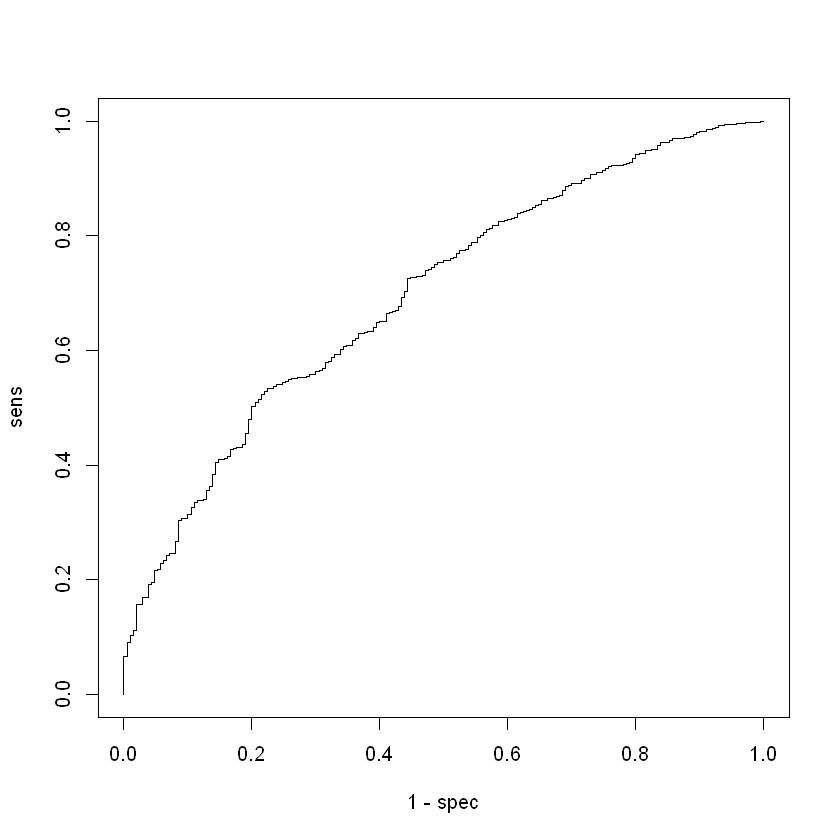

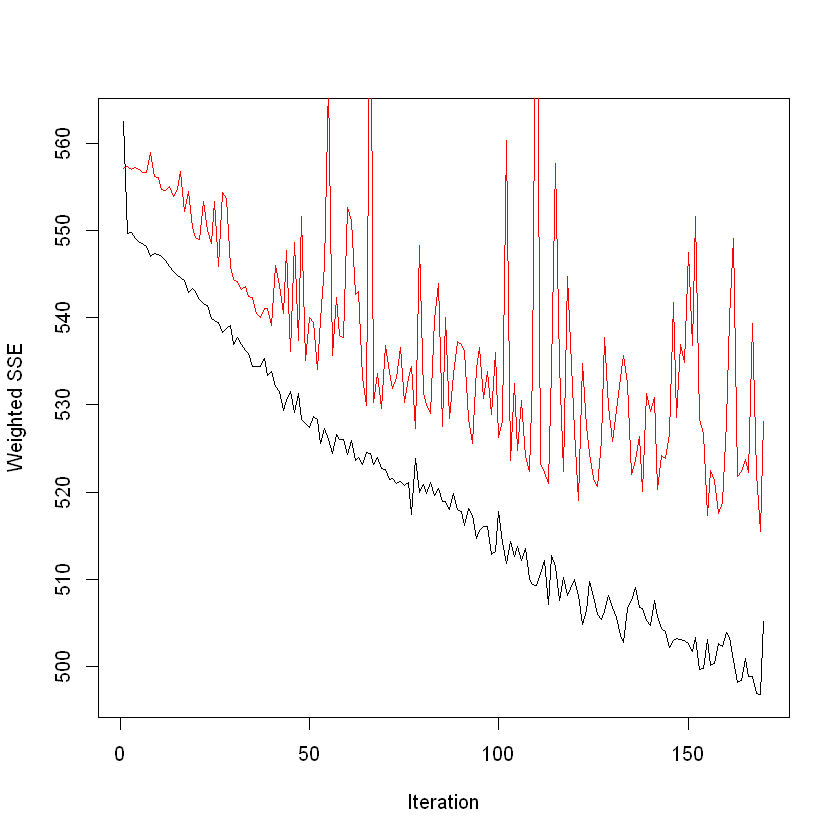

In [192]:
predictions <- predict(model, VAL_WE)
plotROC(predictions[,1], VAL_WY[,1])
plotIterativeError(model)

In [193]:
predictions <- round(predictions, 0)

predictions <- factor(apply(predictions, 1, which.max) - 1, levels = c(0, 1))

actuals <- factor(apply(VAL_WY, 1, which.max) - 1, levels = c(0, 1))

confusionMatrix(actuals, predictions)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1594    4
         1  206    4
                                          
               Accuracy : 0.8838          
                 95% CI : (0.8682, 0.8983)
    No Information Rate : 0.9956          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0284          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.88556         
            Specificity : 0.50000         
         Pos Pred Value : 0.99750         
         Neg Pred Value : 0.01905         
             Prevalence : 0.99558         
         Detection Rate : 0.88164         
   Detection Prevalence : 0.88385         
      Balanced Accuracy : 0.69278         
                                          
       'Positive' Class : 0               
                        

Wnioski
1. Jedyny sensowny wynik jak uzyskałem podczas testowania to model z jedną warstwą ukrytą z 15 nuronami, przy parametrze learning reate = 0.01. Dokładność modelu jest wysoka: 88,38%, natomiast Kappa wynosi 2%, co oznacza, iż model bardzo słabo dostosowywuje się do nowych danych

Pakiet NEURALNET

In [420]:
library(neuralnet)
library(caret)
library(RSNNS)

In [421]:
nnet <- neuralnet(y ~ . , data=bank_train1, hidden=c(50,50,10,10), linear.output=FALSE)

In [422]:
nnet$result.matrix

error,7.000190475
reached.threshold,0.007444656
steps,745.000000000
Intercept.to.1layhid1,1.610523886
age.to.1layhid1,0.304761835
jobadmin..to.1layhid1,-1.867334698
jobblue.collar.to.1layhid1,-3.743362983
jobentrepreneur.to.1layhid1,-5.568929725
jobhousemaid.to.1layhid1,-7.834186700
jobmanagement.to.1layhid1,-0.165064710
jobretired.to.1layhid1,5.099298032


In [423]:
plot(nnet)

In [424]:
predicted.output=predict(nnet,bank_valid1)


In [425]:
predicted.output=round(predicted.output,0)

In [426]:
print(predicted.output)

     [,1] [,2]
1616    1    0
3534    1    0
3012    1    0
811     1    0
4171    1    0
2522    1    0
1282    1    0
1059    1    0
127     0    1
2670    1    0
1144    1    0
3524    0    1
407     1    0
2232    1    0
371     1    0
4289    1    0
2357    1    0
1296    0    1
3743    1    0
2384    0    1
3882    1    0
2835    1    0
3200    1    0
3333    0    1
489     1    0
3614    1    0
3321    1    0
752     1    0
4055    1    0
3569    1    0
337     1    0
963     1    0
3301    1    0
4036    1    0
1630    1    0
1900    0    1
3860    1    0
2358    1    0
3129    1    0
1856    0    1
1155    1    0
29      1    0
75      1    0
1680    1    0
1000    1    0
669     1    0
2133    1    0
3256    1    0
1199    1    0
2798    0    1
1752    1    0
1890    1    0
2566    1    0
3347    1    0
173     1    0
4252    0    1
1860    1    0
2654    1    0
3683    0    1
3559    0    1
88      1    0
402     1    0
3338    1    0
2335    1    0
1035    1    0
3766    1 

In [427]:
predicted.output=encodeClassLabels(predicted.output)

In [428]:
predicted.output=factor(predicted.output)

In [429]:
predicted.output<-droplevels(predicted.output[predicted.output != "0"])
levels(predicted.output) <- c("0", "1")
len_y <- length(bank_valid1$y)
len_pred <- length(predicted.output)
sum(is.na(bank_valid1$y))
sum(is.na(predicted.output))

bank_valid1 <- bank_valid1[complete.cases(bank_valid1$y), ]
predicted.output <- predicted.output[!is.na(predicted.output)]
len_y <- length(bank_valid1$y)
len_pred <- length(predicted.output)
if (len_y > len_pred) {
  bank_valid1 <- bank_valid1[1:len_pred, ]
} else if (len_pred > len_y) {
  predicted.output <- predicted.output[1:len_y]
}

levels(predicted.output) <- levels(bank_valid1$y)
library(caret)
conf_matrix <- confusionMatrix(bank_valid1$y, predicted.output)
print(conf_matrix)


[1] 0

[1] 0

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1442  128
         1  133   50
                                          
               Accuracy : 0.8511          
                 95% CI : (0.8336, 0.8675)
    No Information Rate : 0.8985          
    P-Value [Acc > NIR] : 1.0000          
                                          
                  Kappa : 0.194           
                                          
 Mcnemar's Test P-Value : 0.8044          
                                          
            Sensitivity : 0.9156          
            Specificity : 0.2809          
         Pos Pred Value : 0.9185          
         Neg Pred Value : 0.2732          
             Prevalence : 0.8985          
         Detection Rate : 0.8226          
   Detection Prevalence : 0.8956          
      Balanced Accuracy : 0.5982          
                                          
       'Positive' Class : 0               
                        

Wnioski
1. Najlepszy model jaki udało mi się uzyska dla zbioru neuralnet jest w opraciu o 4 warstwy ukryte, w których jest następująca liczba neuronów: 50,50,10,10. Dokładność modelu wynosi 85%, natomiast współczynnik kappa około 20%

Modele klasyfikacji, które tworzyliśmy w poprzednim semestrze lepiej sobie radzą z tym zbiorem danych niż MLP multi layer perceptron. Dla tamtych przypadków współczynnik kappa wynosił przeważnie około 50% zatem tamte modele lepiej dostosowywały się do nowych danych